# Hands-on Pruning of Computer Vision Models in PyTorch

## Workshop Overview
Pruning is one of the most practical techniques for reducing the size and computational cost of deep learning models while preserving accuracy. In this workshop, you will learn how to apply unstructured and structured pruning to a CNN trained on CIFAR-10, retrain the pruned model, and measure performance trade-offs.

## Workshop Outline
1. Training a baseline CNN
2. Applying unstructured pruning in PyTorch
3. Applying structured pruning in PyTorch
4. Fine-tuning and retraining the pruned model
5. Evaluating trade-offs

## Setup: Import Required Libraries

We'll import PyTorch, torchvision, and utilities needed for pruning, training, and visualization.

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Part 1: Load and Prepare CIFAR-10 Dataset

CIFAR-10 contains 60,000 32x32 color images across 10 classes. We'll apply normalization to prepare the data for training.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Training samples: 50000
Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Define the CNN Architecture

We'll create a simple CNN with 2 convolutional layers and 2 fully connected layers. This architecture will serve as our baseline model.

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

baseline_model = SimpleCNN().to(device)
print(baseline_model)

total_params = sum(p.numel() for p in baseline_model.parameters())
print(f"\nTotal parameters: {total_params:,}")

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 545,098


## Visualize CNN Architecture

Let's create a visual representation of our CNN architecture to understand the layer structure and parameter counts better.

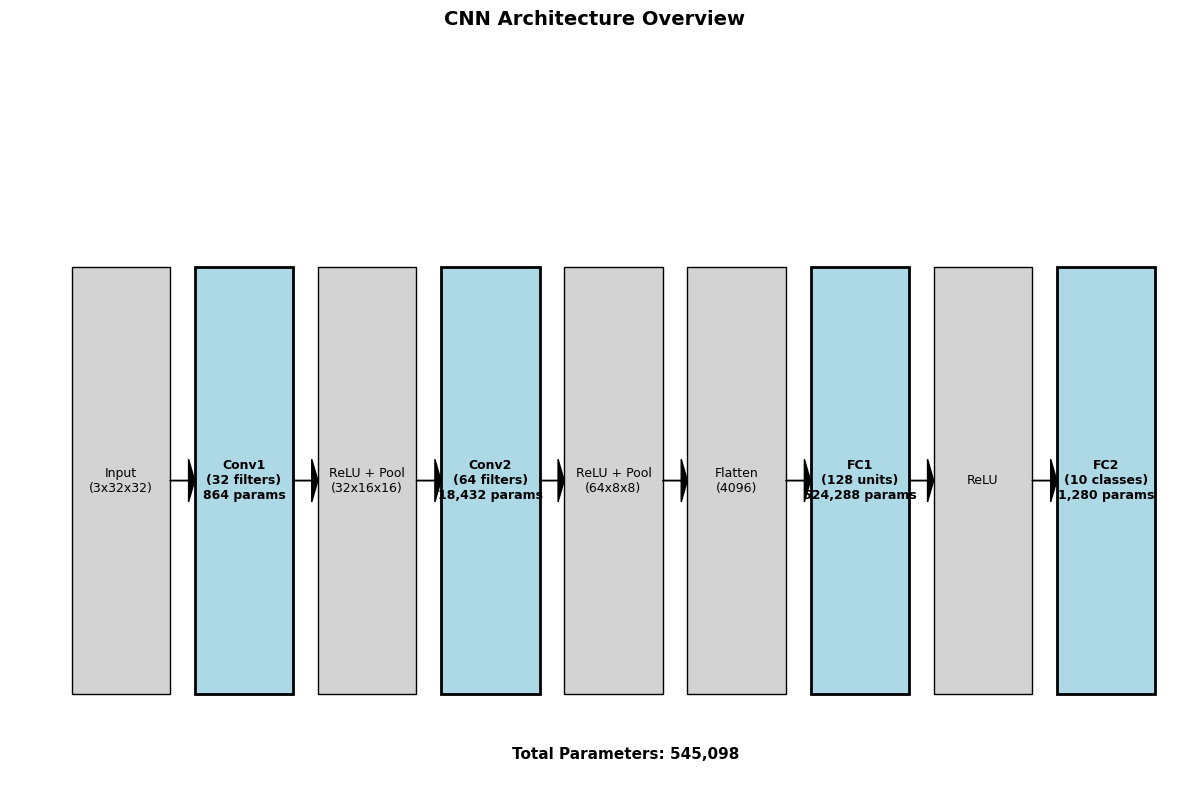

In [4]:
def visualize_model_architecture(model):
    """Visualize the CNN architecture with layer details"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Layer information
    layers = [
        {'name': 'Input\n(3x32x32)', 'pos': 0, 'params': 0},
        {'name': f'Conv1\n(32 filters)\n{model.conv1.weight.numel():,} params', 'pos': 1, 'params': model.conv1.weight.numel()},
        {'name': 'ReLU + Pool\n(32x16x16)', 'pos': 2, 'params': 0},
        {'name': f'Conv2\n(64 filters)\n{model.conv2.weight.numel():,} params', 'pos': 3, 'params': model.conv2.weight.numel()},
        {'name': 'ReLU + Pool\n(64x8x8)', 'pos': 4, 'params': 0},
        {'name': 'Flatten\n(4096)', 'pos': 5, 'params': 0},
        {'name': f'FC1\n(128 units)\n{model.fc1.weight.numel():,} params', 'pos': 6, 'params': model.fc1.weight.numel()},
        {'name': 'ReLU', 'pos': 7, 'params': 0},
        {'name': f'FC2\n(10 classes)\n{model.fc2.weight.numel():,} params', 'pos': 8, 'params': model.fc2.weight.numel()},
    ]
    
    # Draw layers
    for i, layer in enumerate(layers):
        if layer['params'] > 0:
            color = 'lightblue'
            linewidth = 2
        else:
            color = 'lightgray'
            linewidth = 1
        
        rect = plt.Rectangle((i, 0), 0.8, 1, linewidth=linewidth, 
                             edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        ax.text(i + 0.4, 0.5, layer['name'], ha='center', va='center', 
               fontsize=9, weight='bold' if layer['params'] > 0 else 'normal')
        
        # Draw arrows
        if i < len(layers) - 1:
            ax.arrow(i + 0.8, 0.5, 0.15, 0, head_width=0.1, head_length=0.05, 
                    fc='black', ec='black')
    
    ax.set_xlim(-0.5, len(layers))
    ax.set_ylim(-0.2, 1.5)
    ax.axis('off')
    ax.set_title('CNN Architecture Overview', fontsize=14, weight='bold', pad=20)
    
    # Add parameter summary
    total = sum(p.numel() for p in model.parameters())
    ax.text(len(layers)/2, -0.15, f'Total Parameters: {total:,}', 
           ha='center', fontsize=11, weight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_model_architecture(baseline_model)

## Visualize Sample Images

Let's take a look at some example images from the CIFAR-10 dataset to understand what our model will be working with.

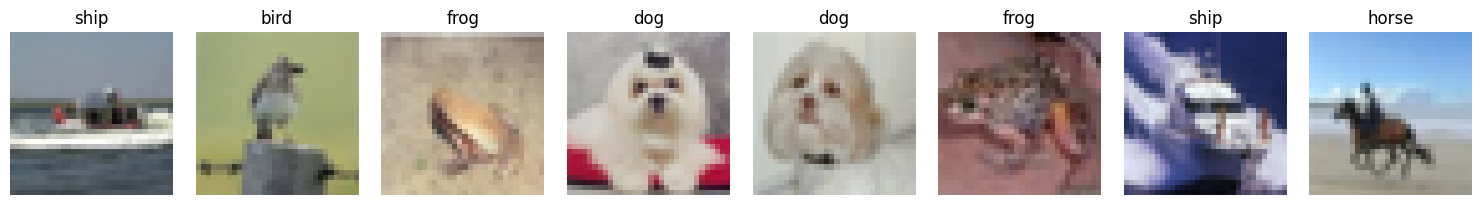


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    axes[i].imshow(np.transpose(images[i].numpy() / 2 + 0.5, (1, 2, 0)))
    axes[i].set_title(train_dataset.classes[labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"\nClasses: {train_dataset.classes}")

## Part 1: Training a Baseline CNN

We'll define training and evaluation functions, then train our baseline model to establish a performance benchmark before pruning.

In [6]:
def train_model(model, train_loader, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

print("Training baseline model...")
train_model(baseline_model, train_loader, epochs=6)
baseline_acc = evaluate_model(baseline_model, test_loader)

Training baseline model...
Epoch 1/6, Loss: 1.3627
Epoch 2/6, Loss: 0.9971
Epoch 3/6, Loss: 0.8445
Epoch 4/6, Loss: 0.7270
Epoch 5/6, Loss: 0.6333
Epoch 6/6, Loss: 0.5476
Accuracy: 72.20%


In [7]:
# Save baseline model
# torch.save(baseline_model.state_dict(), 'baseline_model.pth')
print("Baseline model saved as 'baseline_model.pth'")

Baseline model saved as 'baseline_model.pth'


## Measure Baseline Model Parameters

Before pruning, let's count the total parameters and establish the baseline sparsity (which should be 0%).

In [8]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    nonzero = sum(p.count_nonzero().item() for p in model.parameters())
    sparsity = 100.0 * (total - nonzero) / total
    print(f"Total params: {total}")
    print(f"Non-zero params: {nonzero}")
    print(f"Sparsity: {sparsity:.2f}%")
    return total, nonzero, sparsity

print("\nBaseline Model:")
count_parameters(baseline_model)


Baseline Model:
Total params: 545098
Non-zero params: 545098
Sparsity: 0.00%


(545098, 545098, 0.0)

## Visualize Weight Distributions Before Pruning

Before applying pruning, let's examine the distribution of weights in each layer. This will help us understand what pruning does to the weight distribution.

Weight distributions BEFORE pruning:


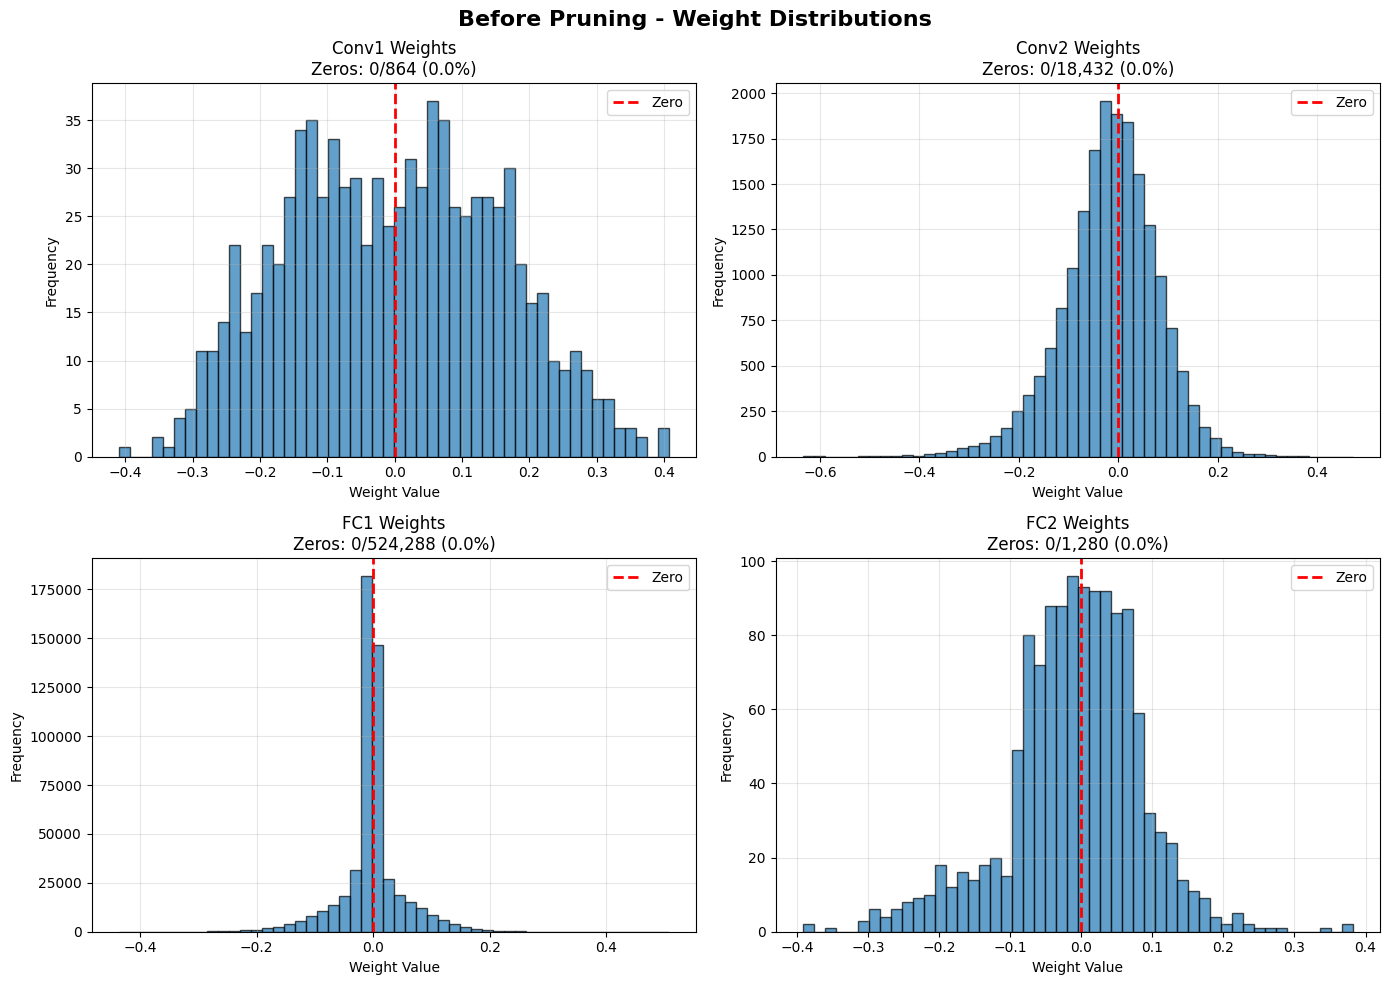

In [9]:
def plot_weight_distributions(model, title_prefix=""):
    """Plot weight distribution histograms for all layers"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{title_prefix}Weight Distributions', fontsize=16, weight='bold')
    
    layers = [
        (model.conv1.weight, 'Conv1 Weights', axes[0, 0]),
        (model.conv2.weight, 'Conv2 Weights', axes[0, 1]),
        (model.fc1.weight, 'FC1 Weights', axes[1, 0]),
        (model.fc2.weight, 'FC2 Weights', axes[1, 1])
    ]
    
    for weights, name, ax in layers:
        weights_np = weights.detach().cpu().numpy().flatten()
        
        # Count zeros
        zero_count = np.sum(weights_np == 0)
        total_count = len(weights_np)
        zero_pct = 100 * zero_count / total_count
        
        # Plot histogram
        ax.hist(weights_np, bins=50, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{name}\nZeros: {zero_count:,}/{total_count:,} ({zero_pct:.1f}%)')
        ax.grid(True, alpha=0.3)
        
        # Add vertical line at zero
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

print("Weight distributions BEFORE pruning:")
plot_weight_distributions(baseline_model, "Before Pruning - ")

## Part 2: Applying Unstructured Pruning

Unstructured pruning removes individual weights based on their magnitude (L1 norm). We'll prune 50% of convolutional layer weights and 70% of fully connected layer weights, then make the pruning permanent.

In [10]:
print("\n=== UNSTRUCTURED PRUNING ===")

# Create a copy of baseline model for unstructured pruning
unstructured_before_finetune = SimpleCNN().to(device)
unstructured_before_finetune.load_state_dict(baseline_model.state_dict())

prune.l1_unstructured(unstructured_before_finetune.conv1, name='weight', amount=0.5)
prune.l1_unstructured(unstructured_before_finetune.conv2, name='weight', amount=0.5)
prune.l1_unstructured(unstructured_before_finetune.fc1, name='weight', amount=0.7)
prune.l1_unstructured(unstructured_before_finetune.fc2, name='weight', amount=0.7)

prune.remove(unstructured_before_finetune.conv1, 'weight')
prune.remove(unstructured_before_finetune.conv2, 'weight')
prune.remove(unstructured_before_finetune.fc1, 'weight')
prune.remove(unstructured_before_finetune.fc2, 'weight')

print("\nAfter Unstructured Pruning (made permanent):")

count_parameters(unstructured_before_finetune)
print("Unstructured model (before fine-tuning) saved as 'unstructured_before_finetune.pth'")

torch.save(unstructured_before_finetune.state_dict(), 'unstructured_before_finetune.pth')

print("\nAccuracy after pruning (before fine-tuning):")# Save the unstructured model before fine-tuning

pruned_acc_before = evaluate_model(unstructured_before_finetune, test_loader)


=== UNSTRUCTURED PRUNING ===

After Unstructured Pruning (made permanent):
Total params: 545098
Non-zero params: 167552
Sparsity: 69.26%
Unstructured model (before fine-tuning) saved as 'unstructured_before_finetune.pth'

Accuracy after pruning (before fine-tuning):
Accuracy: 54.26%


## Visualize Weight Distributions After Pruning

Now let's see how pruning changed the weight distributions. Notice the spike at zero showing the pruned weights.

Weight distributions AFTER pruning:


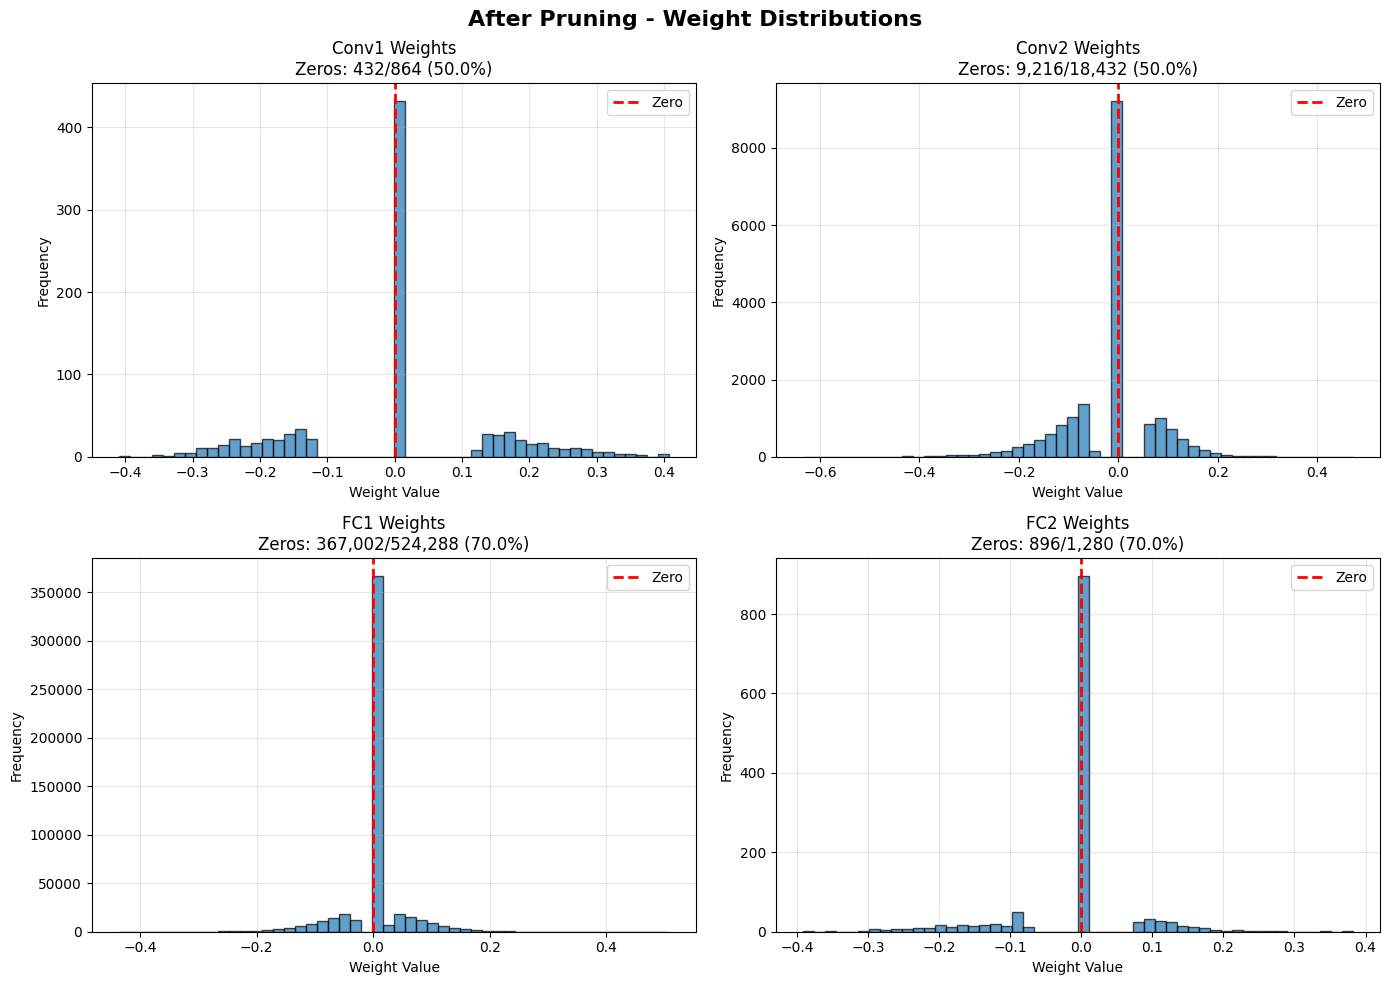

In [11]:
print("Weight distributions AFTER pruning:")
plot_weight_distributions(unstructured_before_finetune, "After Pruning - ")

## Visualize Sparsity Patterns in Weight Matrices

Let's visualize where the zeros are located in the weight matrices. We'll compare the baseline (unpruned) model with the pruned model to see exactly where weights were removed.

**Color Legend:**
- **Black/Dark pixels** = Active weights (non-zero, still in the model)
- **White/Light pixels** = Pruned weights (zeros, removed from the model)

**What to expect:**
- **Baseline**: Almost entirely black (0% sparsity = all weights active)
- **Pruned**: Black background with white dots/patches scattered throughout (showing the 30-50% pruned weights)

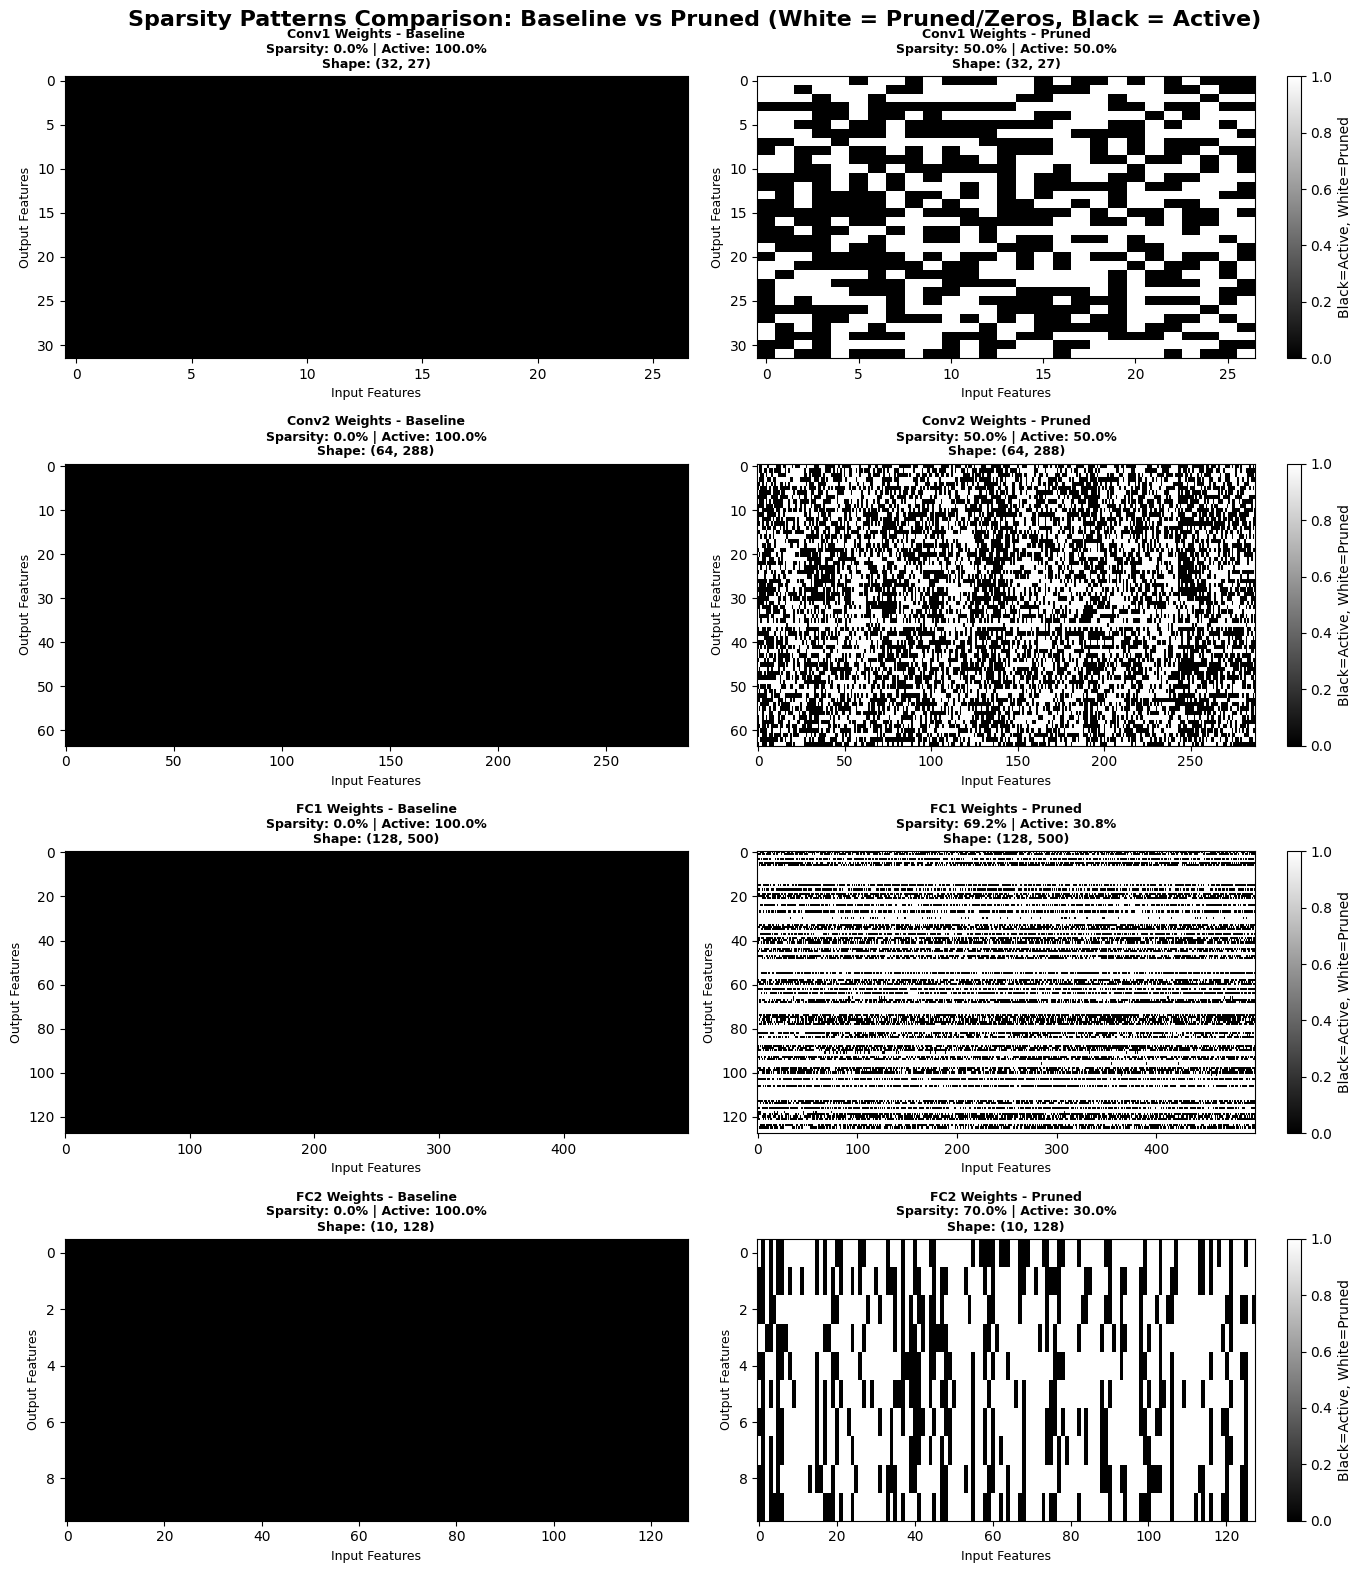

In [12]:
def visualize_sparsity_patterns_comparison(baseline_model, pruned_model):
    """Visualize where zeros are in the weight matrices - compare baseline vs pruned"""
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))
    fig.suptitle('Sparsity Patterns Comparison: Baseline vs Pruned (White = Pruned/Zeros, Black = Active)', 
                 fontsize=16, weight='bold')
    
    # Layer names and model pairs
    layer_configs = [
        ('conv1', 'Conv1 Weights', 0),
        ('conv2', 'Conv2 Weights', 1),
        ('fc1', 'FC1 Weights', 2),
        ('fc2', 'FC2 Weights', 3)
    ]
    
    for layer_attr, name, row in layer_configs:
        # Get weights from both models
        baseline_weights = getattr(baseline_model, layer_attr).weight.detach().cpu().numpy()
        pruned_weights = getattr(pruned_model, layer_attr).weight.detach().cpu().numpy()
        
        # Process both weight matrices
        for col, (weights_np, model_name) in enumerate([(baseline_weights, 'Baseline'), 
                                                          (pruned_weights, 'Pruned')]):
            ax = axes[row, col]
            
            # For conv layers (4D), reshape to 2D for visualization
            if len(weights_np.shape) == 4:
                # Reshape: (out_channels, in_channels, h, w) -> (out_channels, in_channels*h*w)
                out_c, in_c, h, w = weights_np.shape
                weights_2d = weights_np.reshape(out_c, in_c * h * w)
            else:
                # FC layers are already 2D, but might be too large
                weights_2d = weights_np
                # If too large, sample a portion
                if weights_2d.shape[1] > 500:
                    weights_2d = weights_2d[:, :500]
            
            # Create binary mask (1 for zero weights/pruned, 0 for non-zero/active)
            # This way: Black = Active, White = Pruned (easier to see sparse patterns)
            sparsity_mask = (weights_2d == 0).astype(float)
            
            # Count sparsity
            zero_count = np.sum(weights_2d == 0)
            total_count = weights_2d.size
            sparsity_pct = 100 * zero_count / total_count
            
            # Count non-zero weights for verification
            nonzero_count = np.sum(weights_2d != 0)
            active_pct = 100 * nonzero_count / total_count
            
            # Display - using gray colormap: 0=Black (active), 1=White (pruned)
            im = ax.imshow(sparsity_mask, cmap='gray', aspect='auto', interpolation='nearest', vmin=0, vmax=1)
            ax.set_title(f'{name} - {model_name}\nSparsity: {sparsity_pct:.1f}% | Active: {active_pct:.1f}%\nShape: {weights_2d.shape}',
                        fontsize=9, weight='bold')
            ax.set_xlabel('Input Features', fontsize=9)
            ax.set_ylabel('Output Features', fontsize=9)
            
            # Add colorbar only for the right column
            if col == 1:
                plt.colorbar(im, ax=ax, label='Black=Active, White=Pruned')
    
    plt.tight_layout()
    plt.show()

# Compare baseline vs unstructured pruned model
visualize_sparsity_patterns_comparison(baseline_model, unstructured_before_finetune)

## Visualize Predictions Before Fine-tuning

Let's see how the pruned model performs on sample images before we fine-tune it. We'll compare against the baseline accuracy.

Predictions from UNSTRUCTURED PRUNED model (before fine-tuning):


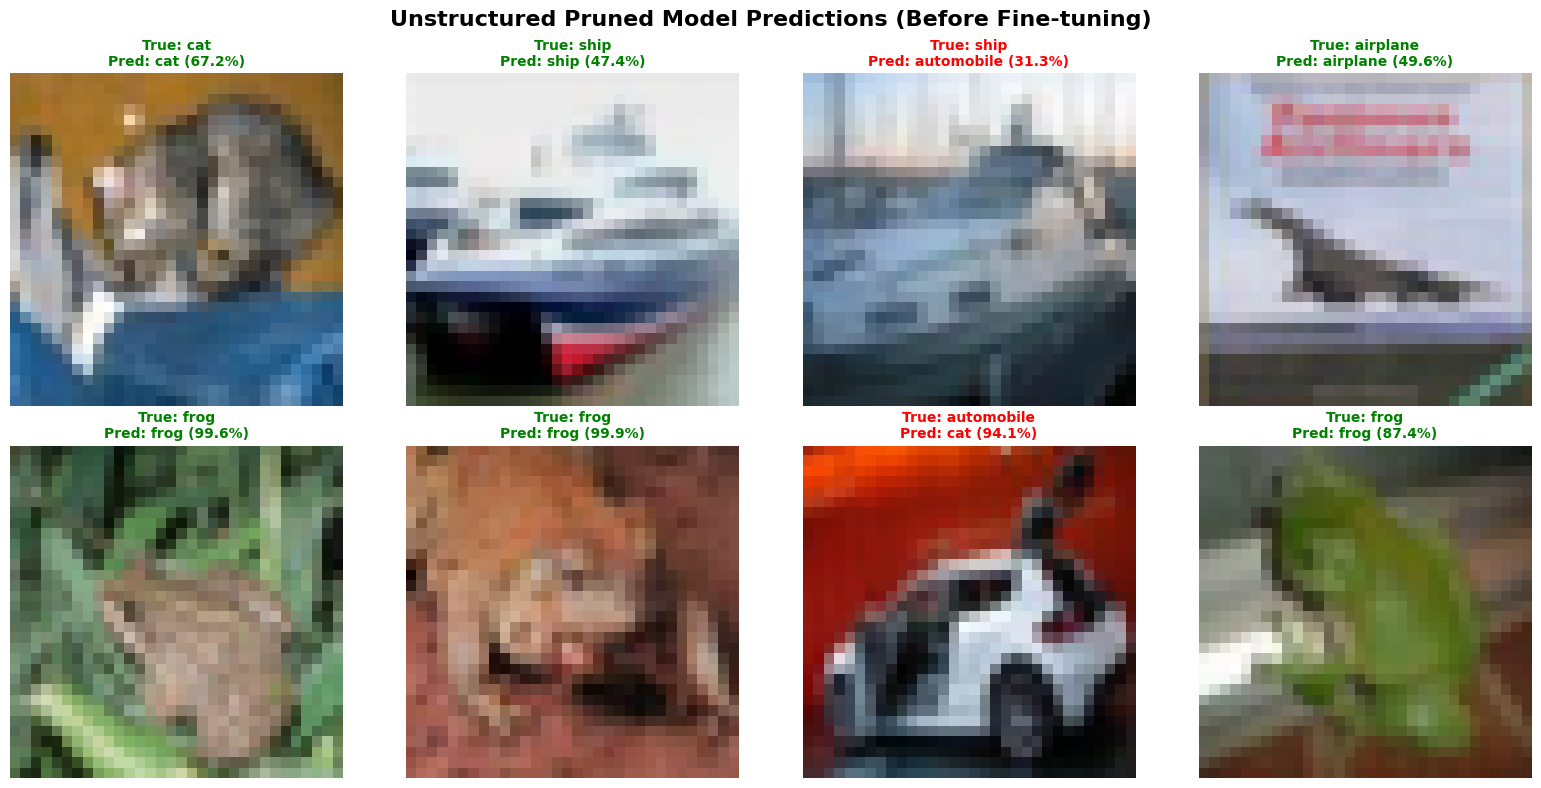

Batch accuracy: 59.38% (38/64 correct)


In [13]:
def visualize_predictions(model, test_loader, num_images=8, title="Predictions"):
    """Visualize model predictions on sample images"""
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    # Move back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(title, fontsize=16, weight='bold')
    
    for idx in range(num_images):
        ax = axes[idx // 4, idx % 4]
        
        # Display image
        img = images[idx] / 2 + 0.5  # Unnormalize
        img = img.numpy()
        ax.imshow(np.transpose(img, (1, 2, 0)))
        
        # Get true and predicted labels
        true_label = test_dataset.classes[labels[idx]]
        pred_label = test_dataset.classes[predicted[idx]]
        confidence = probabilities[idx][predicted[idx]].item() * 100
        
        # Color: green if correct, red if wrong
        color = 'green' if labels[idx] == predicted[idx] else 'red'
        
        ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                    color=color, fontsize=10, weight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy for this batch
    correct = (predicted == labels).sum().item()
    batch_acc = 100 * correct / len(labels)
    print(f"Batch accuracy: {batch_acc:.2f}% ({correct}/{len(labels)} correct)")

print("Predictions from UNSTRUCTURED PRUNED model (before fine-tuning):")
visualize_predictions(unstructured_before_finetune, test_loader, num_images=8, 
                     title="Unstructured Pruned Model Predictions (Before Fine-tuning)")

##  Fine-tuning the Unstructured Pruned Model

After pruning, we retrain the model to recover accuracy lost due to weight removal. This process helps the remaining weights adapt to compensate for the pruned connections.

In [14]:
# Create a copy for fine-tuning
unstructured_after_finetune = SimpleCNN().to(device)
unstructured_after_finetune.load_state_dict(unstructured_before_finetune.state_dict())

print("\nFine-tuning unstructured pruned model...")
train_model(unstructured_after_finetune, train_loader, epochs=3)

pruned_acc_after = evaluate_model(unstructured_after_finetune, test_loader)

# Save the unstructured model after fine-tuning
torch.save(unstructured_after_finetune.state_dict(), 'unstructured_after_finetune.pth')
print("Unstructured model (after fine-tuning) saved as 'unstructured_after_finetune.pth'")


Fine-tuning unstructured pruned model...
Epoch 1/3, Loss: 0.4950
Epoch 2/3, Loss: 0.4064
Epoch 3/3, Loss: 0.3344
Accuracy: 71.60%
Unstructured model (after fine-tuning) saved as 'unstructured_after_finetune.pth'


In [15]:
print(f"\nBaseline Accuracy: {baseline_acc:.2f}%")
print(f"Unstructured Pruned (before fine-tune): {pruned_acc_before:.2f}%")
print(f"Unstructured Pruned (after fine-tune): {pruned_acc_after:.2f}%")


Baseline Accuracy: 72.20%
Unstructured Pruned (before fine-tune): 54.26%
Unstructured Pruned (after fine-tune): 71.60%


## Visualize Predictions After Fine-tuning

Now let's see how the same model performs after fine-tuning. This demonstrates the importance of retraining after pruning.

Predictions from UNSTRUCTURED PRUNED model (after fine-tuning):


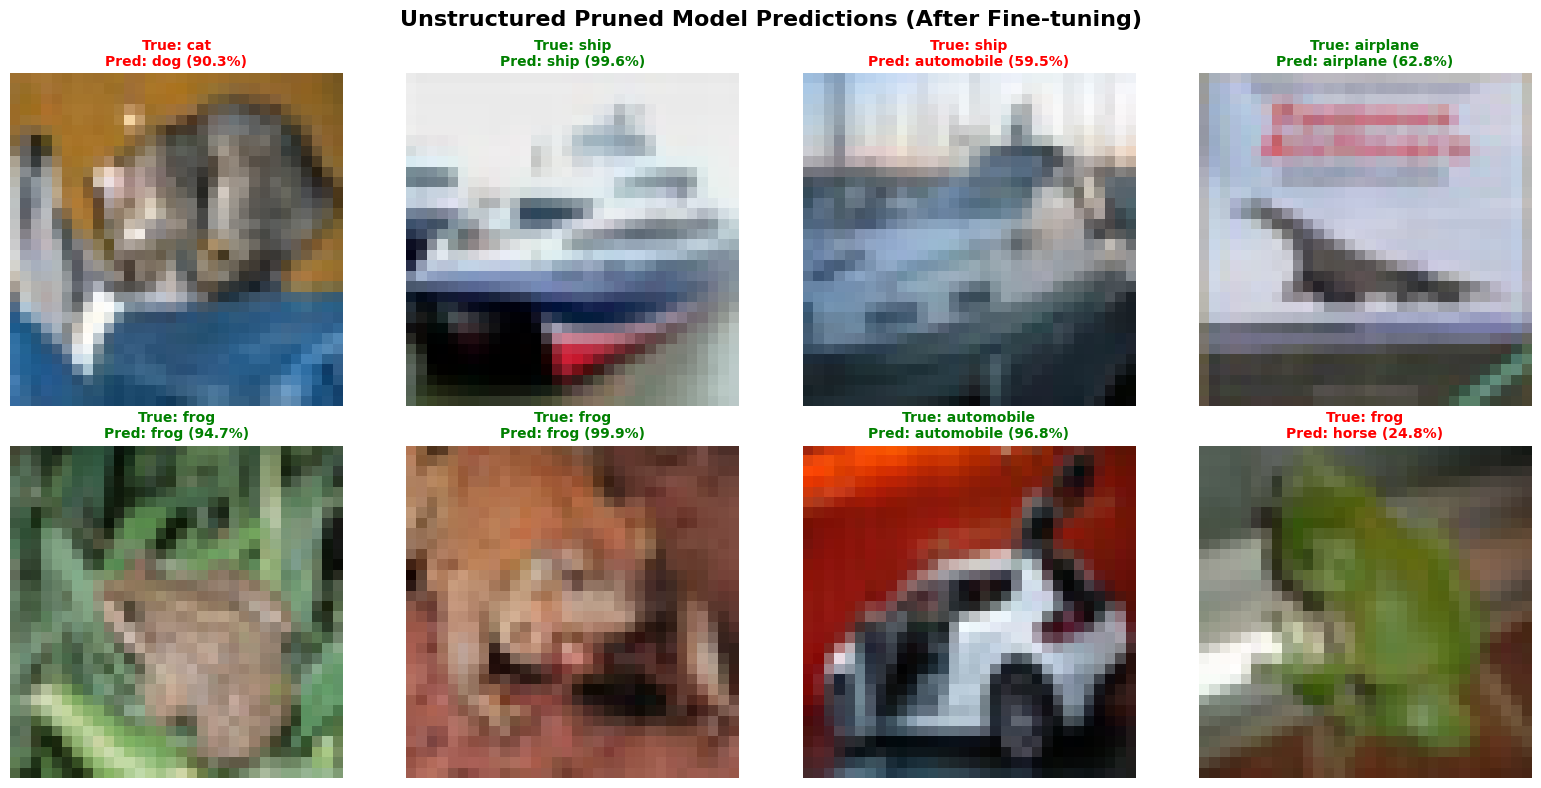

Batch accuracy: 73.44% (47/64 correct)


In [16]:
print("Predictions from UNSTRUCTURED PRUNED model (after fine-tuning):")
visualize_predictions(unstructured_after_finetune, test_loader, num_images=8, 
                     title="Unstructured Pruned Model Predictions (After Fine-tuning)")

## Part 3: Applying Structured Pruning

Unlike unstructured pruning which removes individual weights, structured pruning removes entire channels or filters. This can lead to actual speedups in inference. We'll reuse our trained baseline model and apply structured pruning to compare with unstructured pruning.


In [17]:
print("\n=== STRUCTURED PRUNING ===")

# Reuse the baseline model instead of training a new one
print("Using the existing baseline model for structured pruning...")
baseline_structured = baseline_acc  # Use the same baseline accuracy

# Create structured pruned model (before fine-tuning)
structured_before_finetune = SimpleCNN().to(device)
structured_before_finetune.load_state_dict(baseline_model.state_dict())

prune.ln_structured(structured_before_finetune.conv1, name='weight', amount=0.5, n=2, dim=0)
prune.ln_structured(structured_before_finetune.conv2, name='weight', amount=0.5, n=2, dim=0)

prune.remove(structured_before_finetune.conv1, 'weight')
prune.remove(structured_before_finetune.conv2, 'weight')

print("\nAfter Structured Pruning (made permanent):")
count_parameters(structured_before_finetune)

structured_acc_before = evaluate_model(structured_before_finetune, test_loader)

# Save structured model before fine-tuning
torch.save(structured_before_finetune.state_dict(), 'structured_before_finetune.pth')
print("Structured model (before fine-tuning) saved as 'structured_before_finetune.pth'")



=== STRUCTURED PRUNING ===
Using the existing baseline model for structured pruning...

After Structured Pruning (made permanent):
Total params: 545098
Non-zero params: 535450
Sparsity: 1.77%
Accuracy: 48.85%
Structured model (before fine-tuning) saved as 'structured_before_finetune.pth'


Weight distributions AFTER structured pruning:


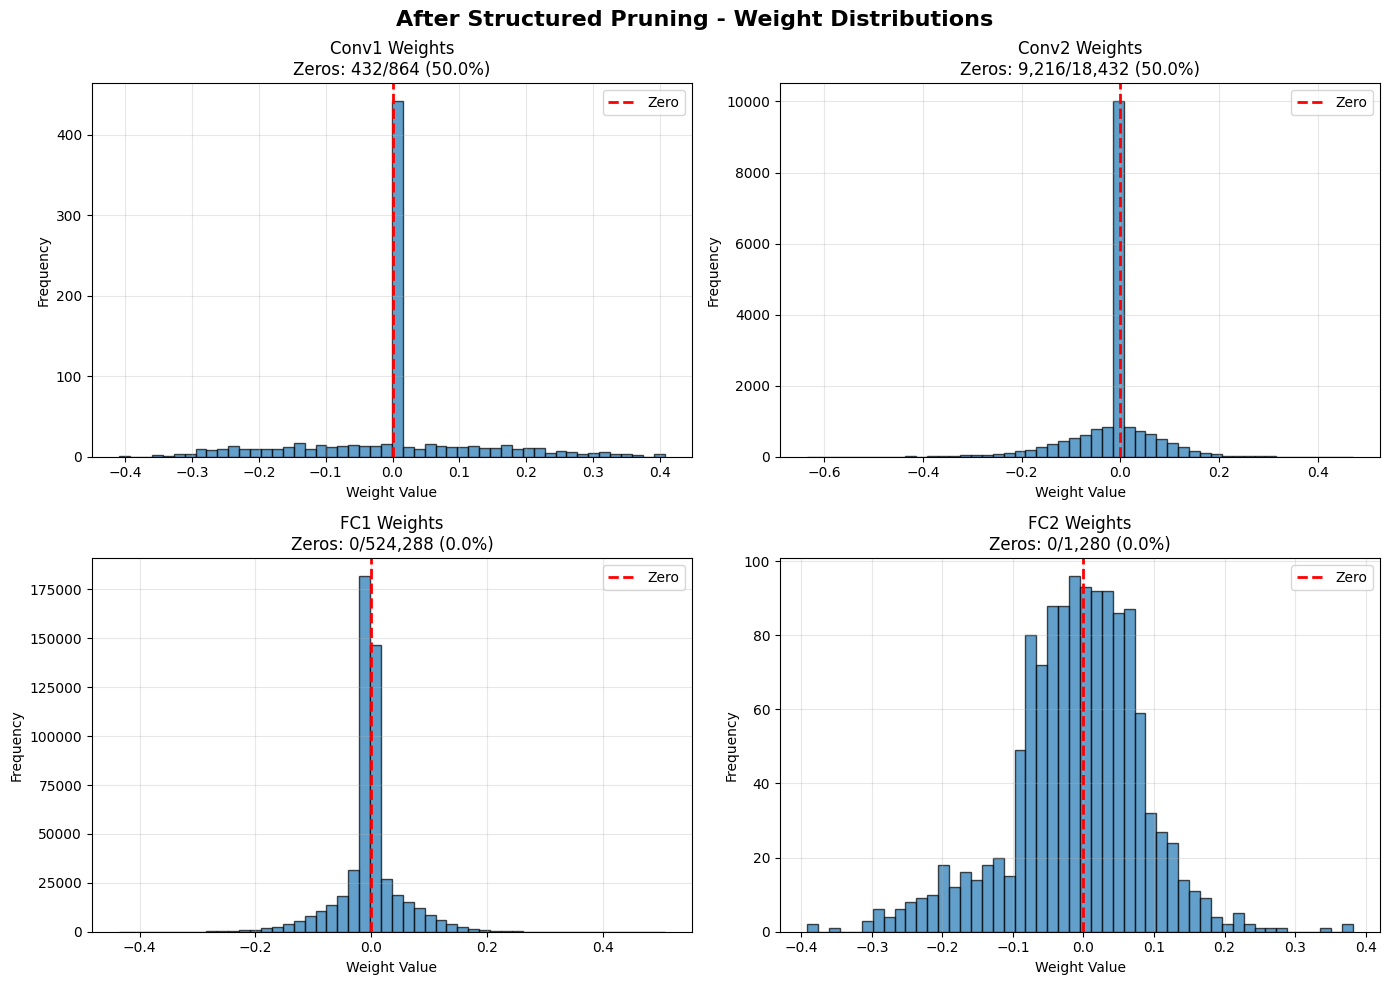

In [18]:
print("Weight distributions AFTER structured pruning:")
plot_weight_distributions(structured_before_finetune, "After Structured Pruning - ")

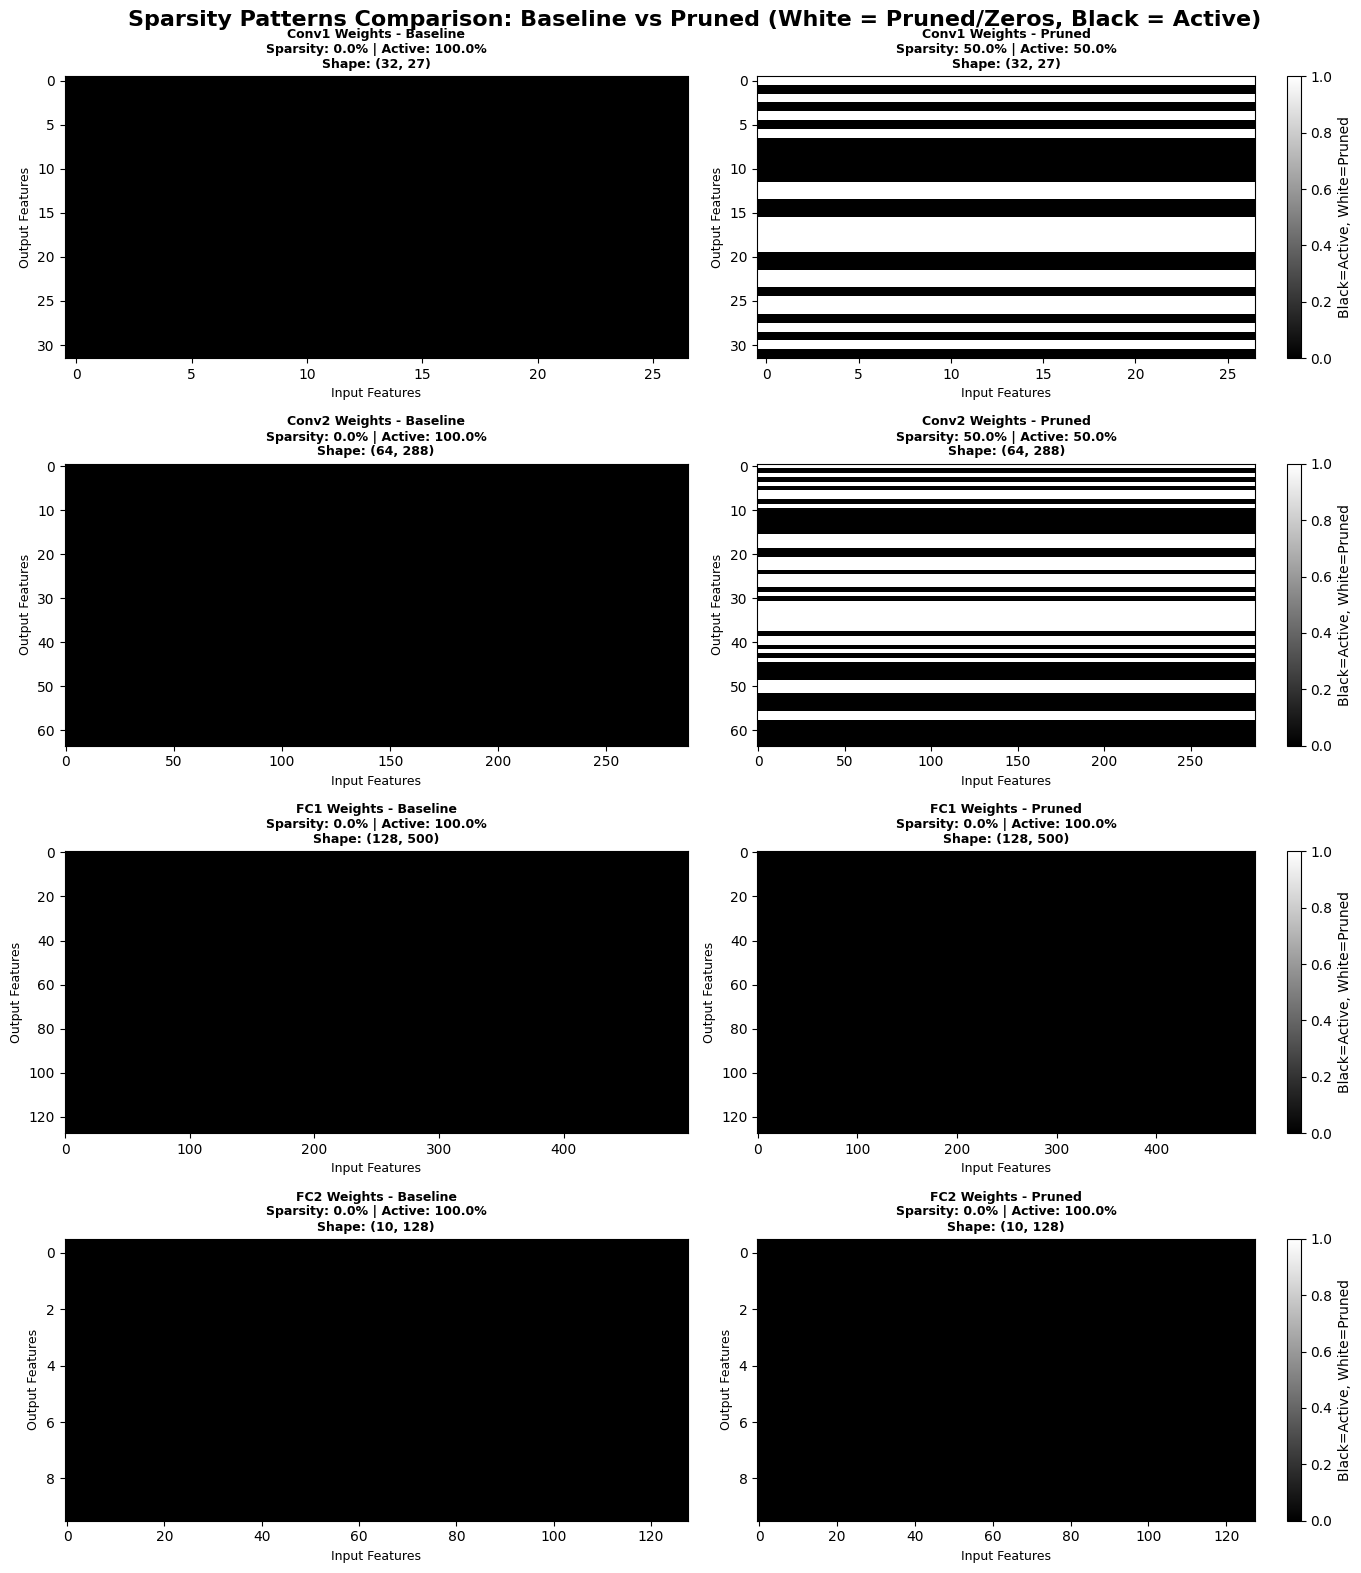

In [19]:
visualize_sparsity_patterns_comparison(baseline_model, structured_before_finetune)

## Visualize Predictions Before Fine-tuning


Predictions from STRUCTURED PRUNED model (before fine-tuning):


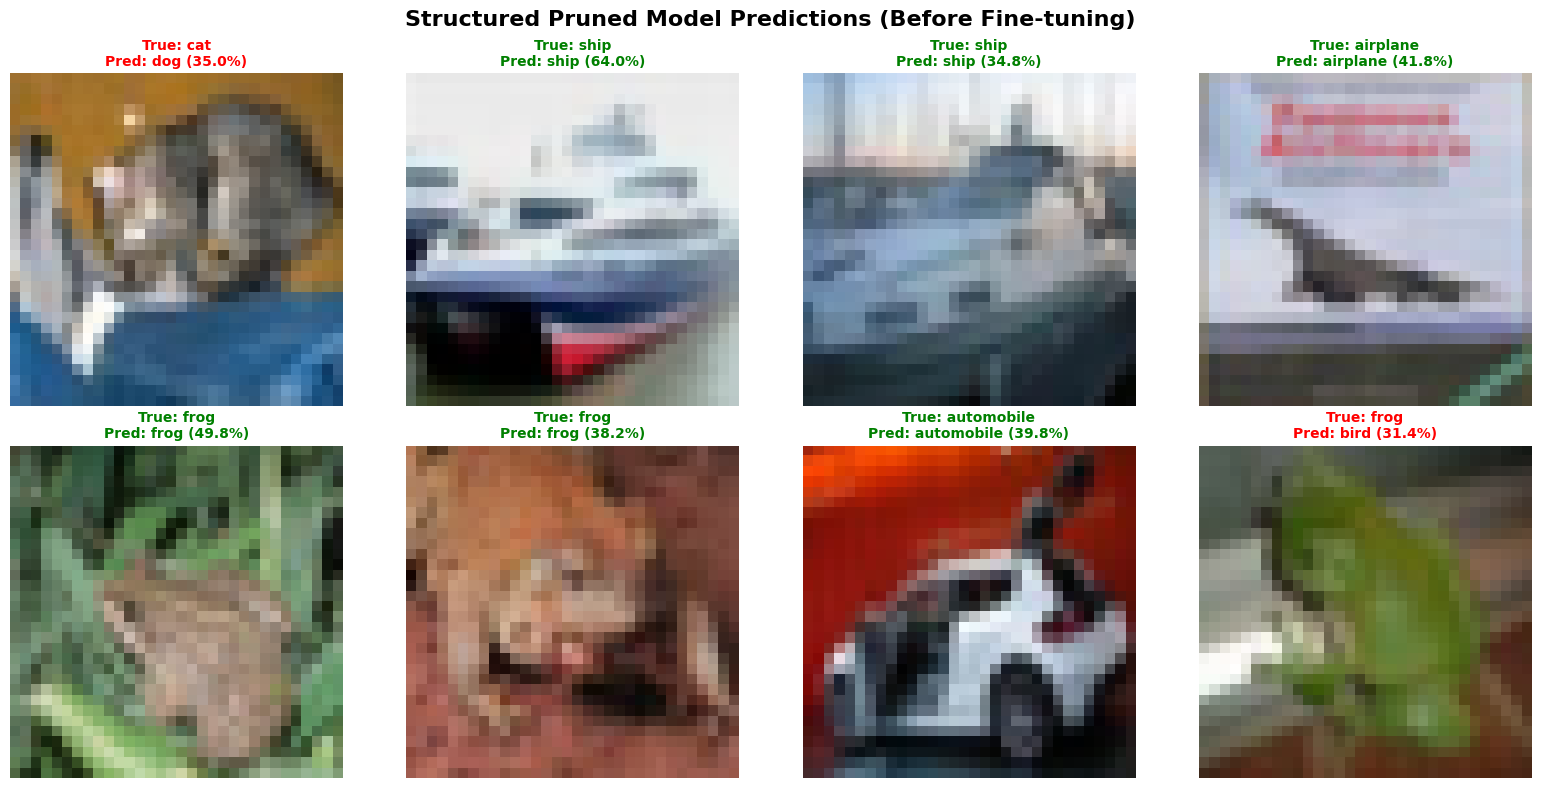

Batch accuracy: 50.00% (32/64 correct)


In [20]:
print("Predictions from STRUCTURED PRUNED model (before fine-tuning):")
visualize_predictions(structured_before_finetune, test_loader, num_images=8, 
                     title="Structured Pruned Model Predictions (Before Fine-tuning)")

##  Fine-tuning the structured Pruned Model

In [21]:
# Create a copy for fine-tuning
structured_after_finetune = SimpleCNN().to(device)
structured_after_finetune.load_state_dict(structured_before_finetune.state_dict())

print("\nFine-tuning structured pruned model...")
train_model(structured_after_finetune, train_loader, epochs=3)
structured_acc_after = evaluate_model(structured_after_finetune, test_loader)

# Save structured model after fine-tuning
torch.save(structured_after_finetune.state_dict(), 'structured_after_finetune.pth')
print("Structured model (after fine-tuning) saved as 'structured_after_finetune.pth'")


Fine-tuning structured pruned model...
Epoch 1/3, Loss: 0.6467
Epoch 2/3, Loss: 0.5276
Epoch 3/3, Loss: 0.4537
Accuracy: 70.65%
Structured model (after fine-tuning) saved as 'structured_after_finetune.pth'


## Visualize Predictions After Fine-tuning


Predictions from STRUCTURED PRUNED model (after fine-tuning):


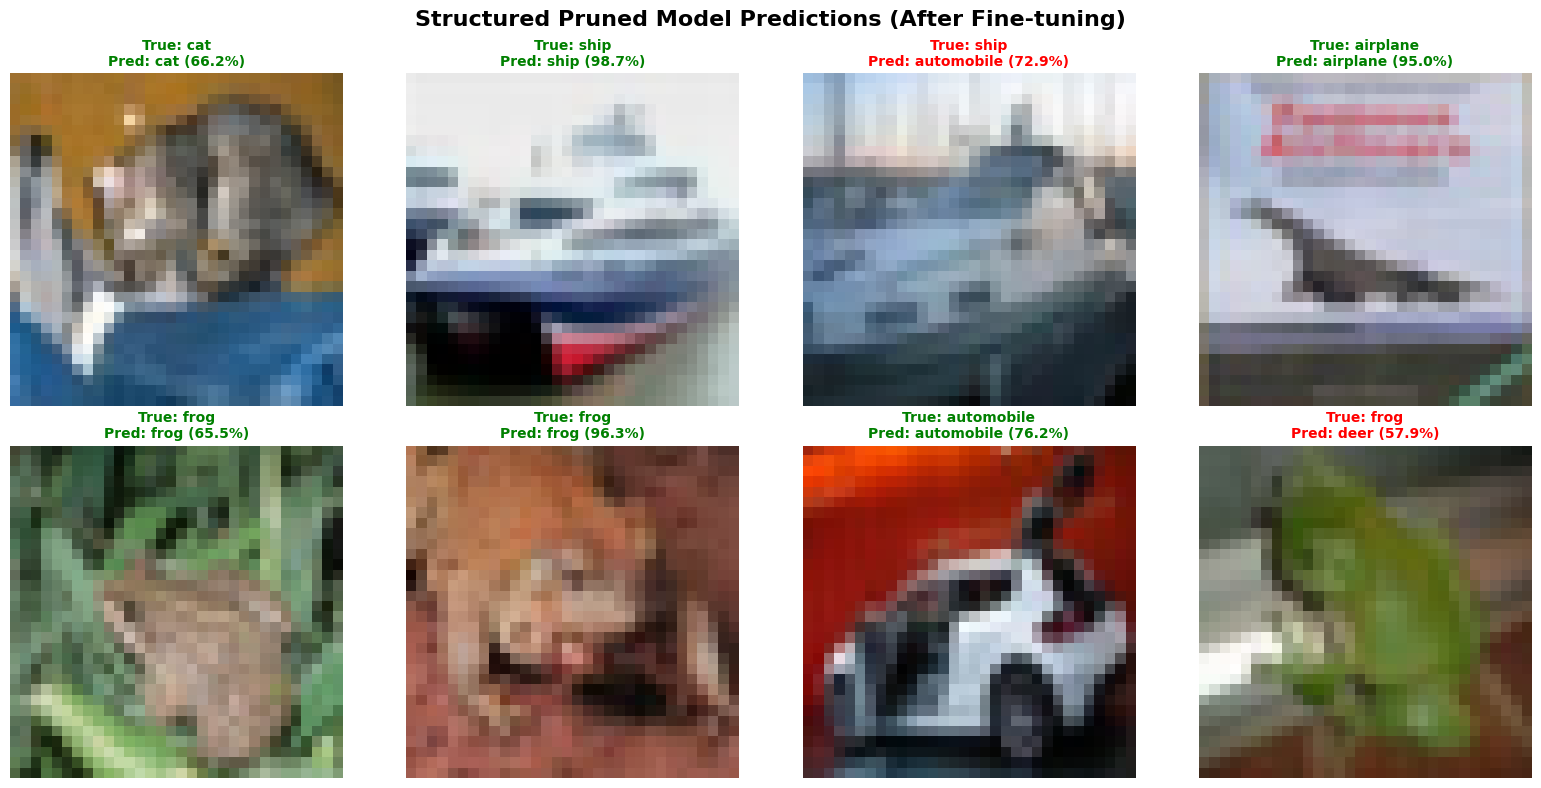

Batch accuracy: 76.56% (49/64 correct)


In [22]:
print("Predictions from STRUCTURED PRUNED model (after fine-tuning):")
visualize_predictions(structured_after_finetune, test_loader, num_images=8, 
                     title="Structured Pruned Model Predictions (After Fine-tuning)")

In [23]:
print(f"\nBaseline (for structured): {baseline_structured:.2f}%")
print(f"Structured Pruned (before fine-tune): {structured_acc_before:.2f}%")
print(f"Structured Pruned (after fine-tune): {structured_acc_after:.2f}%")


Baseline (for structured): 72.20%
Structured Pruned (before fine-tune): 48.85%
Structured Pruned (after fine-tune): 70.65%


## Part 5: Evaluating Trade-offs

Now we'll compare the three models: baseline, unstructured pruned, and structured pruned. We'll visualize both accuracy and sparsity to understand the trade-offs between model compression and performance.

Total params: 545098
Non-zero params: 545098
Sparsity: 0.00%
Total params: 545098
Non-zero params: 327070
Sparsity: 40.00%
Total params: 545098
Non-zero params: 538843
Sparsity: 1.15%


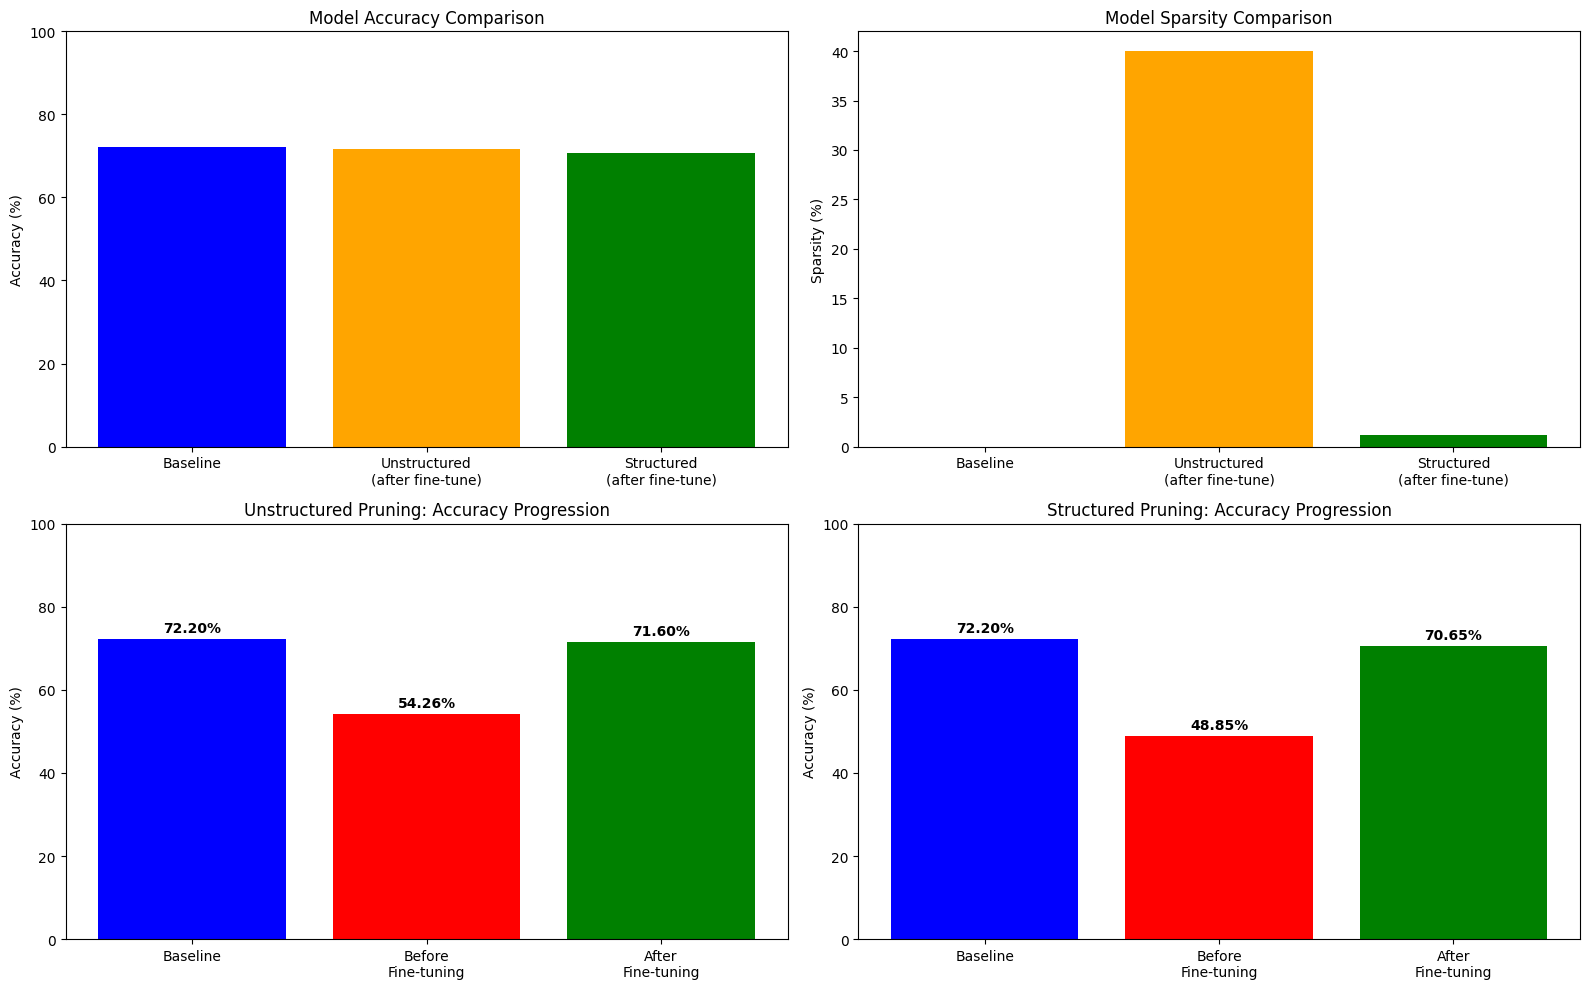

In [24]:
_, _, baseline_sparsity = count_parameters(baseline_model)
_, _, unstructured_sparsity = count_parameters(unstructured_after_finetune)
_, _, structured_sparsity = count_parameters(structured_after_finetune)

results = {
    'Model': ['Baseline', 'Unstructured\n(after fine-tune)', 'Structured\n(after fine-tune)'],
    'Accuracy': [baseline_acc, pruned_acc_after, structured_acc_after],
    'Sparsity': [0, unstructured_sparsity, structured_sparsity]
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Top left: Overall accuracy comparison
ax1.bar(results['Model'], results['Accuracy'], color=['blue', 'orange', 'green'])
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim([0, 100])

# Top right: Overall sparsity comparison
ax2.bar(results['Model'], results['Sparsity'], color=['blue', 'orange', 'green'])
ax2.set_ylabel('Sparsity (%)')
ax2.set_title('Model Sparsity Comparison')

# Bottom left: Unstructured Pruning progression
unstructured_models = ['Baseline', 'Before\nFine-tuning', 'After\nFine-tuning']
unstructured_accuracies = [baseline_acc, pruned_acc_before, pruned_acc_after]
ax3.bar(unstructured_models, unstructured_accuracies, color=['blue', 'red', 'green'])
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Unstructured Pruning: Accuracy Progression')
ax3.set_ylim([0, 100])
for i, v in enumerate(unstructured_accuracies):
    ax3.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# Bottom right: Structured Pruning progression
structured_models = ['Baseline', 'Before\nFine-tuning', 'After\nFine-tuning']
structured_accuracies = [baseline_structured, structured_acc_before, structured_acc_after]
ax4.bar(structured_models, structured_accuracies, color=['blue', 'red', 'green'])
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Structured Pruning: Accuracy Progression')
ax4.set_ylim([0, 100])
for i, v in enumerate(structured_accuracies):
    ax4.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

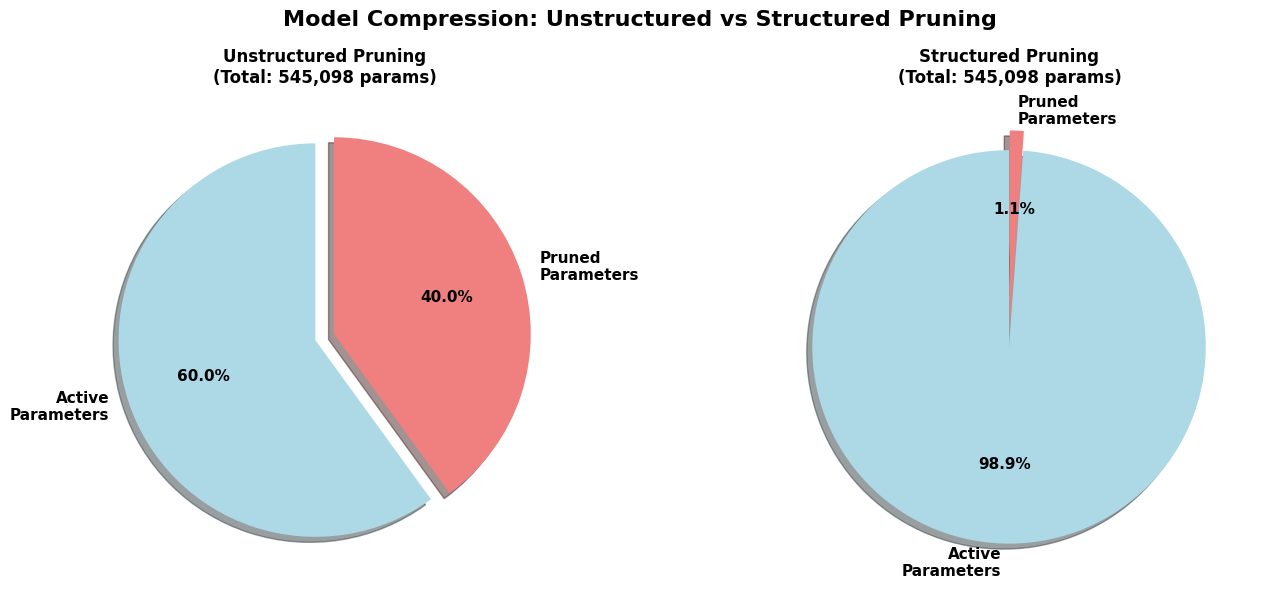


COMPREHENSIVE PRUNING SUMMARY

>>> UNSTRUCTURED PRUNING <<<
--------------------------------------------------------------------------------
Baseline Accuracy:                    72.20%
After Pruning (before fine-tune):     54.26%
After Fine-tuning:                    71.60%

Model Compression:                    40.0% parameters removed
Active Parameters:                    327,070 / 545,098

>>> STRUCTURED PRUNING <<<
--------------------------------------------------------------------------------
Baseline Accuracy:                    72.20%
After Pruning (before fine-tune):     48.85%
After Fine-tuning:                    70.65%

Model Compression:                    1.1% parameters removed
Active Parameters:                    538,843 / 545,098



In [25]:
# Comprehensive Pruning Analysis - Model Compression Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Compression: Unstructured vs Structured Pruning', 
             fontsize=16, weight='bold')

# Calculate parameters for unstructured pruning
unstructured_total = sum(p.numel() for p in unstructured_after_finetune.parameters())
unstructured_active = sum(p.count_nonzero().item() for p in unstructured_after_finetune.parameters())
unstructured_pruned = unstructured_total - unstructured_active

# Calculate parameters for structured pruning
structured_total = sum(p.numel() for p in structured_after_finetune.parameters())
structured_active = sum(p.count_nonzero().item() for p in structured_after_finetune.parameters())
structured_pruned = structured_total - structured_active

# 1. Unstructured Pruning Pie Chart
labels = ['Active\nParameters', 'Pruned\nParameters']
sizes_unstructured = [unstructured_active, unstructured_pruned]
colors = ['lightblue', 'lightcoral']
explode = (0.05, 0.05)

wedges1, texts1, autotexts1 = ax1.pie(sizes_unstructured, explode=explode, labels=labels, 
                                        colors=colors, autopct='%1.1f%%', shadow=True, 
                                        startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
ax1.set_title(f'Unstructured Pruning\n(Total: {unstructured_total:,} params)', 
              fontsize=12, weight='bold')

# 2. Structured Pruning Pie Chart
sizes_structured = [structured_active, structured_pruned]

wedges2, texts2, autotexts2 = ax2.pie(sizes_structured, explode=explode, labels=labels, 
                                        colors=colors, autopct='%1.1f%%', shadow=True, 
                                        startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
ax2.set_title(f'Structured Pruning\n(Total: {structured_total:,} params)', 
              fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("\n" + "="*80)
print("COMPREHENSIVE PRUNING SUMMARY")
print("="*80)

# Unstructured Pruning Statistics
print("\n>>> UNSTRUCTURED PRUNING <<<")
print("-" * 80)
print(f"Baseline Accuracy:                    {baseline_acc:.2f}%")
print(f"After Pruning (before fine-tune):     {pruned_acc_before:.2f}%")
print(f"After Fine-tuning:                    {pruned_acc_after:.2f}%")
print(f"\nModel Compression:                    {100*unstructured_pruned/unstructured_total:.1f}% parameters removed")
print(f"Active Parameters:                    {unstructured_active:,} / {unstructured_total:,}")

# Structured Pruning Statistics
print("\n>>> STRUCTURED PRUNING <<<")
print("-" * 80)
print(f"Baseline Accuracy:                    {baseline_structured:.2f}%")
print(f"After Pruning (before fine-tune):     {structured_acc_before:.2f}%")
print(f"After Fine-tuning:                    {structured_acc_after:.2f}%")
print(f"\nModel Compression:                    {100*structured_pruned/structured_total:.1f}% parameters removed")
print(f"Active Parameters:                    {structured_active:,} / {structured_total:,}")

print("\n" + "="*80)

## Error Analysis: Comparing Mistakes

Let's compare examples where the pruned model makes mistakes before fine-tuning but corrects them after fine-tuning.

Finding examples where fine-tuning corrected mistakes...


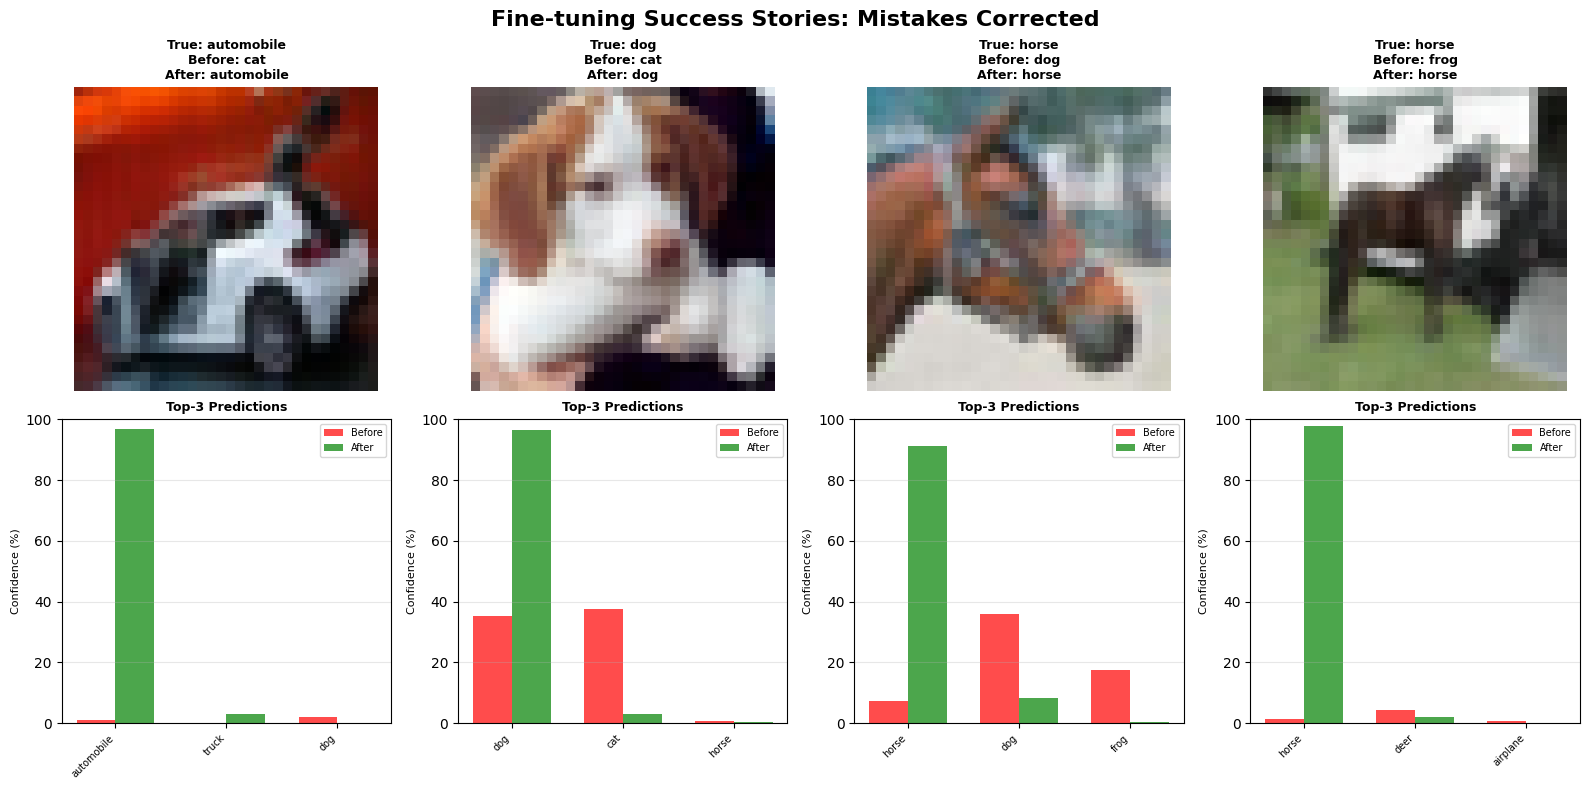


Found 4 examples where fine-tuning corrected mistakes!


In [26]:
def find_improvement_examples(model_before, model_after, test_loader, num_examples=4):
    """Find examples where model_after is correct but model_before was wrong"""
    model_before.eval()
    model_after.eval()
    
    improved_examples = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get predictions from both models
            outputs_before = model_before(images)
            outputs_after = model_after(images)
            
            _, pred_before = torch.max(outputs_before, 1)
            _, pred_after = torch.max(outputs_after, 1)
            
            # Find improvements
            for i in range(len(labels)):
                if pred_before[i] != labels[i] and pred_after[i] == labels[i]:
                    improved_examples.append({
                        'image': images[i].cpu(),
                        'label': labels[i].cpu().item(),
                        'pred_before': pred_before[i].cpu().item(),
                        'pred_after': pred_after[i].cpu().item(),
                        'conf_before': torch.nn.functional.softmax(outputs_before[i], dim=0).cpu(),
                        'conf_after': torch.nn.functional.softmax(outputs_after[i], dim=0).cpu()
                    })
                    
                    if len(improved_examples) >= num_examples:
                        break
            
            if len(improved_examples) >= num_examples:
                break
    
    return improved_examples

# Find examples where fine-tuning helped
print("Finding examples where fine-tuning corrected mistakes...")
improved = find_improvement_examples(unstructured_before_finetune, unstructured_after_finetune, test_loader, num_examples=4)

if len(improved) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Fine-tuning Success Stories: Mistakes Corrected', fontsize=16, weight='bold')
    
    for idx, example in enumerate(improved):
        # Display image
        ax_img = axes[0, idx]
        img = example['image'] / 2 + 0.5  # Unnormalize
        ax_img.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        
        true_label = test_dataset.classes[example['label']]
        pred_before = test_dataset.classes[example['pred_before']]
        pred_after = test_dataset.classes[example['pred_after']]
        
        ax_img.set_title(f'True: {true_label}\nBefore: {pred_before}\nAfter: {pred_after}',
                        fontsize=9, weight='bold')
        ax_img.axis('off')
        
        # Display confidence comparison
        ax_conf = axes[1, idx]
        top_classes = torch.topk(example['conf_after'], 3).indices.numpy()
        
        x = np.arange(3)
        width = 0.35
        
        conf_before_vals = [example['conf_before'][c].item() * 100 for c in top_classes]
        conf_after_vals = [example['conf_after'][c].item() * 100 for c in top_classes]
        
        ax_conf.bar(x - width/2, conf_before_vals, width, label='Before', alpha=0.7, color='red')
        ax_conf.bar(x + width/2, conf_after_vals, width, label='After', alpha=0.7, color='green')
        
        ax_conf.set_ylabel('Confidence (%)', fontsize=8)
        ax_conf.set_title('Top-3 Predictions', fontsize=9, weight='bold')
        ax_conf.set_xticks(x)
        ax_conf.set_xticklabels([test_dataset.classes[c] for c in top_classes], 
                               rotation=45, ha='right', fontsize=7)
        ax_conf.legend(fontsize=7)
        ax_conf.set_ylim([0, 100])
        ax_conf.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFound {len(improved)} examples where fine-tuning corrected mistakes!")
else:
    print("No improvement examples found in this batch. Try running more test batches.")